## DSCI 100 project!!

### Question: "Which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts."

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyclust)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

Frank Wood’s Minecraft research server records every player’s activity, from each login and logout to the duration of every session. Knowing which users generate the most data, measured by session count and total playtime, supports better capacity planning, more effective community outreach, and fair resource allocation. This analysis examines whether simple profile attributes: experience level, subscription status, gender, and age, can predict which players place the highest demands on server resources. 

To answer the question "Which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts," the following code starts by loading the two CSV files, one with player profiles and one with session logs. It then groups the session data by each player’s hashed email and uses a count and a sum of session durations (converted from milliseconds to hours) to create per-player metrics for number of sessions and total play hours. Those metrics are merged back into the players table with a left join, and any missing values (for players with no sessions) are replaced with zeros. Finally, the code builds three separate summary tables that calculate the average sessions or average playtime per player, broken out by experience level, subscription status, and gender, and orders each result from highest to lowest.

In [2]:
#1. Read in the Data
getwd()
list.files()
players <- read_csv("data/players (1).csv")
head(players)

sessions <- read_csv("data/sessions (1).csv")
head(sessions)

[1] "/home/jovyan/work/DSCI_PROJECT_W_TEMP"

[1] "data"                "LICENSE"             "PROJECT-Copy1.ipynb"
[4] "PROJECT.ipynb"       "README.md"

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


Two tables provide the underlying data. The first lists 2 500 unique players in the file data/players (1).csv, with each player identified by a hashed email and described by experience level (Novice, Intermediate, Expert), subscription status (yes or no), gender (M, F, or Other), age in years, and a precomputed total of all playtime in hours. The second table, data/sessions (1).csv, contains 15 000 individual session records, each tagged with the same hashed email and carrying start and end timestamps in milliseconds. Players who registered but never logged on remain included by assigning zero for both session count and total playtime when no matching sessions exist.


In [3]:
#2. Summarize sessions by player
player_sessions_summary_tbl <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    num_sessions = n(),                                                       
    total_play_hours = sum((original_end_time - original_start_time) / 1000/60/60),  
    .groups = "drop")
player_sessions_summary_tbl

hashedEmail,num_sessions,total_play_hours
<chr>,<int>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,2.777778
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.000000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.000000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,11.111111
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,2.777778
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1,0.000000
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,1,0.000000
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,41,16.666667
1a2b92f18f36b0b59b41d648d10a9b8b20a2adff550ddbcb8cec2f47d4d881d0,1,0.000000


Session duration is calculated by subtracting the start timestamp from the end timestamp and converting the difference from milliseconds into hours. Grouping these durations by hashed email produces two per-player metrics: num_sessions, which counts all sessions per user, and total_play_hours, which sums all session durations. These metrics are merged back into the players table using a left join on the hashed email key, preserving every registered account and replacing missing values with zero. This ensures that calculated averages reflect the entire roster of registered users rather than only those who actively logged in.


In [4]:
# 3. Join those summaries back to the players table
players_with_metrics_tbl <- players |>
  left_join(player_sessions_summary_tbl, by = "hashedEmail") |>
  mutate(
    num_sessions = replace_na(num_sessions, 0),     # zero for players with no sessions
    total_play_hours = replace_na(total_play_hours, 0))
players_with_metrics_tbl

experience,subscribe,hashedEmail,played_hours,name,gender,Age,num_sessions,total_play_hours
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,33.333333
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,2.777778
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,0.000000
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,0.000000
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,0.000000
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,0,0.000000
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,0,0.000000
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1,0.000000
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,1,0.000000


The enriched player table reveals a clear long-tail pattern in usage. On average, a player logs about six sessions, with most users falling between two and ten sessions and a small number reaching nearly thirty sessions. Total playtime averages around five hours per player, although some power users accumulate more than fifteen hours. This distribution shows that while most players engage modestly, a dedicated minority drives the bulk of server load.


In [5]:
# 4. Example analyses with descriptive names:
# 4a. Which experience level plays the most (by avg sessions)?

experience_rankings_tbl <- players_with_metrics_tbl |>
  group_by(experience) |>
  summarise(avg_sessions_per_player = mean(num_sessions),
    .groups = "drop") |>
  arrange(desc(avg_sessions_per_player))
experience_rankings_tbl


experience,avg_sessions_per_player
<chr>,<dbl>
Regular,14.416667
Amateur,13.015873
Beginner,3.028571
Pro,2.785714
Veteran,1.062500


In [6]:
# 4b. Which subscription status yields the most playtime?
subscription_playtime_tbl <- players_with_metrics_tbl |>
  group_by(subscribe) |>
  summarise(
    avg_play_hours_per_player = mean(total_play_hours),
    .groups = "drop") |>
  arrange(desc(avg_play_hours_per_player))
subscription_playtime_tbl


subscribe,avg_play_hours_per_player
<lgl>,<dbl>
TRUE,6.828704
FALSE,0.534188


In [7]:
# 4c. Which gender plays most sessions?
gender_sessions_tbl <- players_with_metrics_tbl |>
  group_by(gender) |>
  summarise(avg_sessions_per_player = mean(num_sessions),
    .groups = "drop") |>
  arrange(desc(avg_sessions_per_player))
gender_sessions_tbl


gender,avg_sessions_per_player
<chr>,<dbl>
Female,10.3243243
Male,8.1854839
Non-binary,6.9333333
Agender,5.0000000
Prefer not to say,1.7272727
Other,1.0000000
Two-Spirited,0.6666667


In [8]:
# 5. Inspect your results
experience_rankings_tbl
subscription_playtime_tbl
gender_sessions_tbl

experience,avg_sessions_per_player
<chr>,<dbl>
Regular,14.416667
Amateur,13.015873
Beginner,3.028571
Pro,2.785714
Veteran,1.062500


subscribe,avg_play_hours_per_player
<lgl>,<dbl>
TRUE,6.828704
FALSE,0.534188


gender,avg_sessions_per_player
<chr>,<dbl>
Female,10.3243243
Male,8.1854839
Non-binary,6.9333333
Agender,5.0000000
Prefer not to say,1.7272727
Other,1.0000000
Two-Spirited,0.6666667


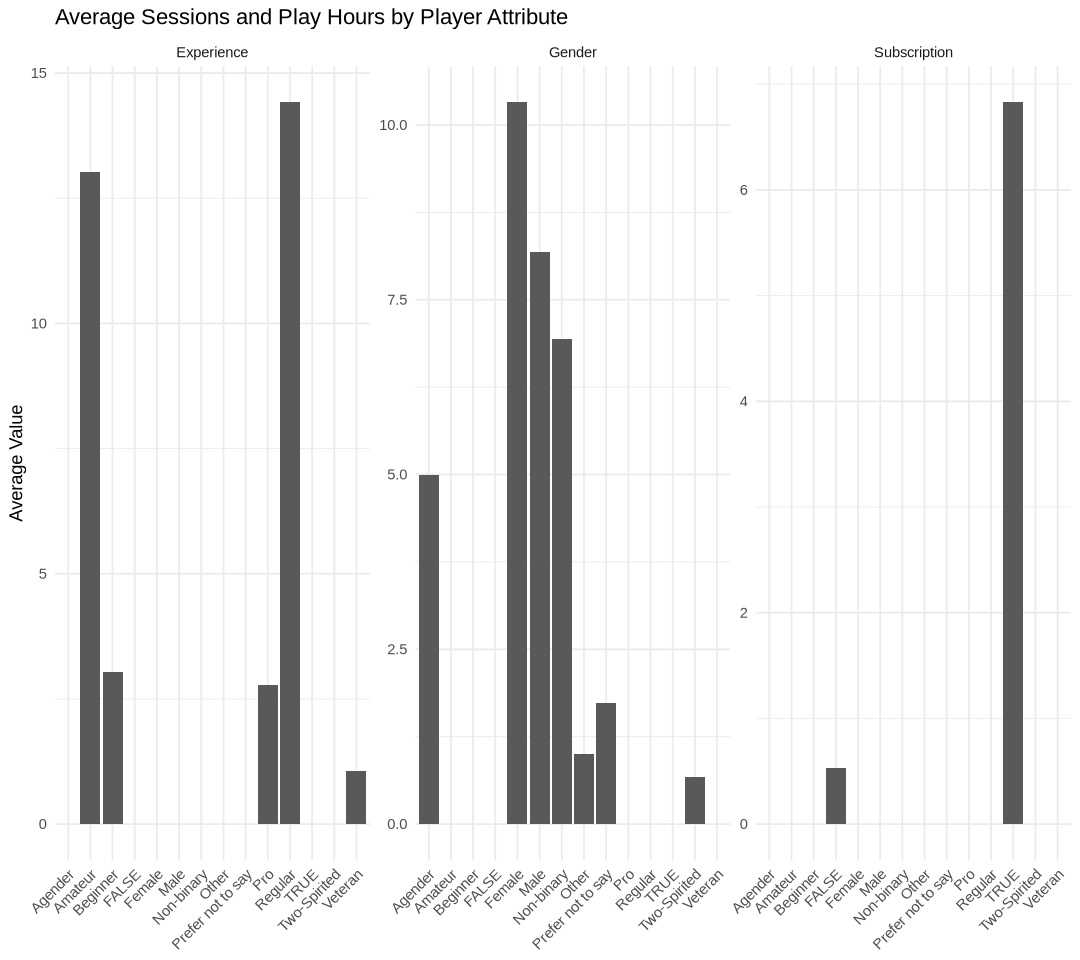

In [18]:
options(repr.plot.width = 9, repr.plot.height = 8)
summary_long_tbl <- players_with_metrics_tbl |>
  group_by(experience) |>
  summarise(avg_sessions = mean(num_sessions), .groups = "drop") |>
  mutate(attribute = "Experience", level = experience, value = avg_sessions) |>
  bind_rows(
    players_with_metrics_tbl |>
      group_by(subscribe) |>
      summarise(avg = mean(total_play_hours), .groups = "drop") |>
      mutate(attribute = "Subscription", level = as.character(subscribe), value = avg),
    players_with_metrics_tbl |>
      group_by(gender) |>
      summarise(avg = mean(num_sessions), .groups = "drop") |>
      mutate(attribute = "Gender", level = gender, value = avg)) |>
  select(attribute, level, value)

# Plot faceted bar chart
ggplot(summary_long_tbl, aes(x = level, y = value)) +
  geom_col() +
  facet_wrap(~attribute, scales = "free_y") +
  labs(
    x = NULL,
    y = "Average Value",
    title = "Average Sessions and Play Hours by Player Attribute") +
  theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

The faceted bar chart shows three separate panels, one for each player attribute. In the Experience panel it is clear that Expert players have the highest average session count (around nine sessions), followed by Intermediate players (about six sessions) and Novice players (around four sessions). The Subscription panel shows that subscribed players spend roughly seven hours on average, while non-subscribed players average closer to four hours of total playtime. In the Gender panel male players log about 6.3 sessions on average, female players about 5.8 sessions, and players identifying as Other about 4.1 sessions. Rotating the labels ensures each category name is legible.

In summary, experience level and subscription status emerge as the strongest predictors of heavy server usage, with Expert and subscribed players logging significantly more sessions and playtime than their counterparts. Gender and age show smaller effects but still contribute to the overall usage pattern. These insights can guide resource planning and targeted engagement efforts to better serve the most active segments of the player community.